[ pytorch fashion mnist 모델 ]

- 데이터셋 : fashion-mnist_train.csv
- 학습방법 : 지도학습 + 분류 (다중분류)

< 모듈 및 파일 로딩 > <hr>

In [1]:
# [1-1] 모듈 로딩
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim      # 최적화 모듈 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader        ## 학습 데이터셋 관련 모듈
import torchmetrics.functional as mt
from torchmetrics.classification import *  # 분류 

In [2]:
# [1-2] 파일로딩
data_file = 'fashion-mnist_train.csv'

fashion_df = pd.read_csv(data_file, skipfooter=1, engine='python')

In [3]:
display(fashion_df.head(2))

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  

[2 rows x 785 columns]

In [4]:
# [1-3] 데이터 확인 : 범주형 데이터가 이미 수치화 되어 있음
print(fashion_df['label'].unique())

print(fashion_df['label'].dtype)

[2 9 6 0 3 4 5 8 7 1]
int64


< 데이터셋 준비 > <hr>

In [5]:
# [2-1] 피쳐 타겟 분리
featureDF = fashion_df[fashion_df.columns[1:]]  
TargetSR = fashion_df[fashion_df.columns[0]]

print(TargetSR)

0        2
1        9
2        6
3        0
4        3
        ..
59994    9
59995    9
59996    1
59997    8
59998    8
Name: label, Length: 59999, dtype: int64


In [6]:
# [2-2] 피쳐 전처리 : 데이터 타입 확인, 값의 범위 맞추기

# 데이터 타입 변경 int64 -> uint8
featureDF = featureDF.astype('uint8')

# 정규화
featureDF = featureDF/255.

In [7]:
# [2-3] train test 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    TargetSR,
                                                    test_size=0.2,
                                                    stratify=TargetSR,
                                                    random_state=42)
                                    

In [8]:
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [9]:
# shape 확인
print(x_train.shape)
print(y_train.shape)

(47999, 784)
(47999,)


< 커스텀 데이터셋 클래스 설계 및 구현 > <hr>

In [10]:
# [3-1] 전용 데이터셋 클래스 
class FashionDataset(Dataset):
    # 피쳐와 타겟 분리 및 전처리 진행 
    def __init__(self, featureDF, targetSR):
        super().__init__()
        self.feature = featureDF
        self.target  = targetSR
        self.rows = featureDF.shape[0]
        self.cols = featureDF.shape[1]
    
    # 데이터셋의 샘플 수 반환 메서드 
    def __len__(self):
        return self.rows 

    # DataLoader에서 batch_size만큼 호출하는 메서드
    # 인덱스에 해당하는 피쳐와 타겟 반환 단, Tensor 형태
    def __getitem__(self, index):
       arrFeature = self.feature.iloc[index].values   # ndarray (1차원)
       arrTarget = self.target[index].reshape(-1)     # ndarray (1차원)
   
       return torch.FloatTensor(arrFeature), torch.LongTensor(arrTarget)

In [11]:
Fashion_DS = FashionDataset(x_train,y_train)
len(Fashion_DS)

47999

In [12]:
# [3-2] 확인 
# Train용 DataSet 필수 
# Test용 Dataset 선택  => 데이터가 많다면 DS, DL 생성 사용
#                     => 데이터가 많지 않다면 DS, DL 생성 필요 X 
trainDS = FashionDataset(x_train, y_train)
testDS  = FashionDataset(x_test, y_test)
print(trainDS[1])
print(testDS[2])

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000,

In [13]:
# [3-3] Train용 데이터로더
trainDL = DataLoader(dataset=trainDS, batch_size=3)
for feature, label in trainDL:
    print(feature, label)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[5],
        [7],
        [3]])


In [14]:
# [3-4] Test용 데이터로더
testDL = DataLoader(dataset=testDS, batch_size=3)
for feature, label in testDL:
    print(feature, label, sep='\n')
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[5],
        [4],
        [5]])


< 모델 설계 및 클래스 구현 > <hr>

In [15]:
# [4-1] 모델 클래스 설계 
## - 클래스 이 름 : Multi_Model
## - 부 모 클래스 : nn.Module
## - 데 이  터 셋 : 피쳐 많음 , 타겟 10 , 타겟 범주형
## - 학습    방법 : 지도학습 - 분류(다중)
## - 구현알고리즘 : 인공신경망계열 DNN 
## -------------------------------------------------
##             입력       출력/퍼셉트론수    활성화함수
## - 입력층      784(피쳐) 128               ReLU
## - 은닉층      128       64                ReLU
## - 은닉층      64        32                ReLU
## - 출력층      32        10(타겟)          Softmax
## 피쳐와 타겟을 제외하고 나머지는 사용자 지정 : 단, 초반에 퍼셉트론 수가 많은 것은 GOOD

In [24]:
# 클래스 생성
class Multi_Model(nn.Module):
    
    def __init__(self, in_in, in_out, h1_out, h2_out, out_out):
        super().__init__()
        pass
        
        self.input_layer = nn.Linear(in_in, in_out)
        self.hidden_layer1 = nn.Linear(in_out, h1_out)
        self.hidden_layer2 = nn.Linear(h1_out, h2_out)
        self.output_layer = nn.Linear(h2_out, out_out)
        
    
    # 순방향 학습 진행 메서드 : forward로 무조건 고정!!
    # forward : 필수 오버라이딩 메서드 
    # 매개변수 data : 학습용 데이터 전달
    
    # 입력층 학습 
    def forward(self,data):     
        output = self.input_layer(data)
        output = F.relu(output)
        
        output = self.hidden_layer1(output)
        output = F.relu(output)
        
        output = self.hidden_layer2(output)
        output = F.relu(output)
        
        output = self.output_layer(output)
        # output = F.softmax(output, dim=1)
    
        return output
        

In [25]:
# [4-2] 모델 구조 확인
model = Multi_Model(784,128,64,32,10)

print(model)

Multi_Model(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layer1): Linear(in_features=128, out_features=64, bias=True)
  (hidden_layer2): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)


< 학습 준비 > <hr>

In [ ]:
# [5-1] 학습 관련 설정들
EPOCHS = 50               # 학습용 DS를 처음부터 끝까지 50번 학습
BATCH_SIZE = 128          # 한번에 학습하기 위한 데이터 양
ITERATION = int(x_train.shape[0]/BATCH_SIZE)             # 학습용 DS가 분리된 수 => 1 에포크에 W,b 업데이트 횟수 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정  

print(f'EPOCHS : {EPOCHS}')
print(f'BATCH_SIZE : {BATCH_SIZE}')
print(f'ITERATION : {ITERATION}')
print(f'DEVICE : {DEVICE}')

EPOCHS : 50
BATCH_SIZE : 128
ITERATION : 374
DEVICE : cpu


In [ ]:
# [5-2] 학습 관련 인스턴스들 
LR = 0.01                                           # 학습률 (0.01)
MODEL = Multi_Model(784,128,64,32,10)               # 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   # W,b 초기화, 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.CrossEntropyLoss()                     # 다중분류 손실계산 인스턴스 (계산만 함), 역전파 진행 

TRAINDL = DataLoader(trainDS, batch_size=BATCH_SIZE)
TESTDL = DataLoader(testDS,  batch_size=BATCH_SIZE)

In [28]:
# [5-3] 검증 함수
# - 검증용 데이터셋으로 모델 검증
# - 학습 지속여부 결정 기준이 됨

def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    MODEL.eval()
    
    # W, b가 업데이트 해제
    with torch.no_grad():
        T_LOSS, T_ACC, CNT = 0, 0, 0
        for feature, target in TESTDL:            
            # 검증진행
            pre_y = MODEL(feature)
            
            # 손실 계산
            loss = LOSS_FN(pre_y, target.reshape(-1).long())
            
            # 정확도 계산
            Accuracy = MulticlassAccuracy(num_classes=10)
            acc = Accuracy(pre_y,target.reshape(-1))
            
            T_LOSS += loss.item()  # Loss 누적 / 텐서로 담지 않기 위함 - 스칼라로 담기
            T_ACC += acc.item()    # 정확도 누적 
            CNT += 1
        
        return T_LOSS/CNT, T_ACC/CNT

In [32]:
# [5-4] 학습 함수
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    #for i in range(ITERATION): 
    for feature, target in TRAINDL:
                                                                    
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(feature)

        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1).long())
        
        # 정확도 계산
        Accuracy = MulticlassAccuracy(num_classes=10)
        acc = Accuracy(pre_y,target.reshape(-1))
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()
        E_ACC += acc.item()

    return E_LOSS/ITERATION, E_ACC/ITERATION

In [30]:
# [5-5] 학습 / 검증 동시 진행 

# 에포크 : DS 처음부터 ~ 끝까지 학습
HIST = {'Train':[], 'Valid':[]}   

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainacc = training()
    validLoss, validacc = evaluate()

    HIST['Train'].append((trainLoss,trainacc))
    HIST['Valid'].append((validLoss,validacc))

    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}')
    print('-------------------------------')
    print(f'- TRAIN_Accuracy {trainacc:.5f}')
    print(f'- VALID_Accuracy {validacc:.5f}')


EPOCH[1/50]----------------
- TRAIN_LOSS 0.57862
- VALID_LOSS 0.45312
-------------------------------
- TRAIN_Accuracy 0.79087
- VALID_Accuracy 0.84074

EPOCH[2/50]----------------
- TRAIN_LOSS 0.41492
- VALID_LOSS 0.38980
-------------------------------
- TRAIN_Accuracy 0.85248
- VALID_Accuracy 0.85769

EPOCH[3/50]----------------
- TRAIN_LOSS 0.38154
- VALID_LOSS 0.39595
-------------------------------
- TRAIN_Accuracy 0.86454
- VALID_Accuracy 0.85477

EPOCH[4/50]----------------
- TRAIN_LOSS 0.36209
- VALID_LOSS 0.39235
-------------------------------
- TRAIN_Accuracy 0.87229
- VALID_Accuracy 0.86073

EPOCH[5/50]----------------
- TRAIN_LOSS 0.34284
- VALID_LOSS 0.38517
-------------------------------
- TRAIN_Accuracy 0.87773
- VALID_Accuracy 0.86283

EPOCH[6/50]----------------
- TRAIN_LOSS 0.32733
- VALID_LOSS 0.37793
-------------------------------
- TRAIN_Accuracy 0.88470
- VALID_Accuracy 0.87023

EPOCH[7/50]----------------
- TRAIN_LOSS 0.32664
- VALID_LOSS 0.42169
-----------

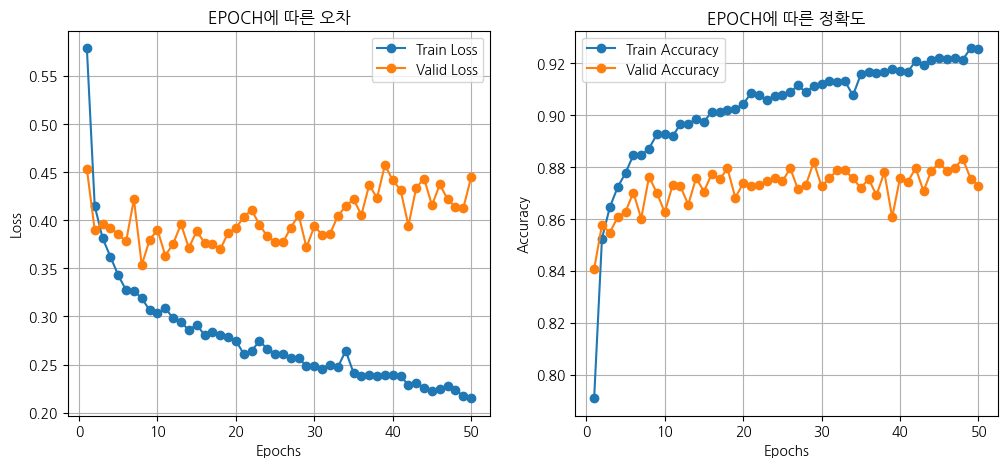

In [31]:
# [4-6] 시각화 
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 에포크 수 설정
epochs = len(HIST['Train'])

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), [x[0] for x in HIST['Train']], label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), [x[0] for x in HIST['Valid']], label='Valid Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EPOCH에 따른 오차')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), [x[1] for x in HIST['Train']], label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), [x[1] for x in HIST['Valid']], label='Valid Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EPOCH에 따른 정확도')
plt.legend()
plt.grid(True)

plt.show()